In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import json
import pandas as pd
import traceback

sys.path.append(".") # add results folder as a python path 
from viz import *
from analyze import *

In [2]:
# Global variables and statistics
dataset = 'data207'
dataset_name = 'ResNet on CIFAR10'
num_trials =100

lookup = load_lookup_data(dataset, '../lookup')
stats = get_difficulty_stats(lookup)
#print(lookup.keys())
n_samples = 7000
total_secs =  sum(lookup.duration)
total_hours = total_secs / 3600
mean_mins = total_secs / n_samples / 60
print(" total:  {:.2f}D, {:.2f}h, mean: {:.2f}M".format(total_hours/24, total_hours, mean_mins))
for s in stats:
    print(s)
s = stats[3]
print("Selected target threshold: {}".format(s))
print("Global optimum: {:.4f}".format(np.max(lookup['best_acc'].values)))


 total:  384.57D, 9229.66h, mean: 79.11M
{'difficulty': 1.0, 'error': 0.072700024000000085, 'accuracy': 0.92729997599999991}
{'difficulty': 0.5, 'error': 0.070699990000000046, 'accuracy': 0.92930000999999995}
{'difficulty': 0.1, 'error': 0.068199992000000043, 'accuracy': 0.93180000799999996}
{'difficulty': 0.05, 'error': 0.066699982000000047, 'accuracy': 0.93330001799999995}
{'difficulty': 0.01, 'error': 0.063199997000000008, 'accuracy': 0.93680000299999999}
Selected target threshold: {'difficulty': 0.05, 'error': 0.066699982000000047, 'accuracy': 0.93330001799999995}
Global optimum: 0.9368


In [3]:
# Read parallel optimization results ( 6 processors)
results_6 = {}
size = 6
opt_secs = 108000
postfix = "({})".format(num_trials)
p_path = "./{}/T{}S/".format(dataset, opt_secs)
results_6['Synch. GP-EI-MCMC(10)'] = load_json(p_path + 'SYNC-BATCH.M6.FO-None.ETR-None.6GP-EI' + postfix + '.json')
results_6['GP-EI-MCMC(10)'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6GP-EI' + postfix + '.json')
results_6['GP-EI-MCMC(1)'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6GP-EI-no_mcmc' + postfix + '.json')
results_6['RF-EI'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6RF-EI' + postfix + '.json')

results_6['RF-PI'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6RF-PI' + postfix + '.json')
results_6['RF-UCB'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6RF-UCB' + postfix + '.json')
results_6['GP-PI'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6GP-PI' + postfix + '.json')
results_6['GP-UCB'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6GP-UCB' + postfix + '.json')

path = "./data207/G0.9334/"
results_6['P-Div (in-progress)'] = load_json(path + 'ASYNC-BATCH.M6.FO-premature.ETR-DecaTercet.hybrid-deca(100)' + '.json')
results_6['P-Div (naive)'] = load_json(path + 'ASYNC-BATCH.M6.FO-None.ETR-DecaTercet.hybrid-deca-no_failover(100).json')
results_6['P-Div (random)'] = load_json(path + 'ASYNC-BATCH.M6.FO-random.ETR-DecaTercet.hybrid-deca-no_failover(100).json')
results_6['P-Div (next candidate)'] = load_json(path+ 'ASYNC-BATCH.M6.FO-next_candidate.ETR-DecaTercet.hybrid-deca-next_cand(100).json')

results_6['P-Div'] = results_6['P-Div (in-progress)']

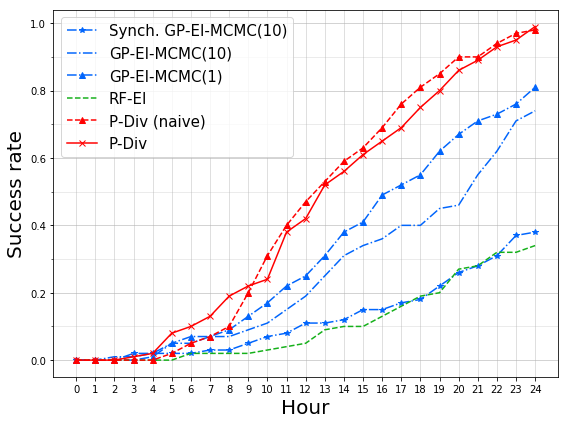

In [4]:
def restyle(name):
    marker = ''
    color ='black'
    line_style = '--'
    if 'GP-EI' in name:
        line_style = '-.'
        color = 'xkcd:bright blue'
    elif 'RF-EI' in name:
        color = 'xkcd:green'
    elif '-Div' in name:
        color = 'red'        
    if 'P-Div' == name:
        marker = 'x'
        line_style = '-'
    elif 'P-Div (naive)' == name:
        marker = '^'
    elif 'P-Div (in-progress)' == name:
        marker = 'x'
        line_style = '-'
    elif 'P-Div (random)' == name:
        marker = 'v' 
    elif 'P-Div (next candidate)' == name:
        marker = 'o'                
    elif 'MCMC(1)' in name:
        marker = '^' 
    elif 'Synch.' in name:
        marker = '*'
    return marker, color, line_style

parallels = ['Synch. GP-EI-MCMC(10)', 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI',  'P-Div (naive)', 'P-Div']
p_g = []
for p in parallels:
    p_g.append({"opt": p})
    
draw_success_rate_fig(results_6, s['accuracy'], 25, 
                                              x_unit='Hour', step_size=1, style_format=restyle, 
                                               parallel=p_g, 
                      width=8, height=6,  save_name='fig-cifar10-resnet-p1', target_folder='./figs/',
                      num_runs=num_trials )

In [5]:
# ablation study result for p-div
path = "./data207/G0.935/"
ab_results = {}
#ab_results['no log, random'] = load_json(path + 'ASYNC-BATCH.M6.FO-random.ETR-None.p6div-no_log-rand(100)' + '.json')
#ab_results['no log, next candidate'] = load_json(path + 'ASYNC-BATCH.M6.FO-next_candidate.ETR-None.p6div-no_log-nc(100)' + '.json')

#ab_results['no log, ETR, random'] = load_json(path + 'ASYNC-BATCH.M6.FO-random.ETR-DecaTercet.p6div-no_log-etr-rand(100)' + '.json')
#ab_results['no log, ETR, next candidate'] = load_json(path + 'ASYNC-BATCH.M6.FO-next_candidate.ETR-DecaTercet.p6div-no_log-etr-nc(100)' + '.json')

#ab_results['hybrid log, random'] = load_json(path + 'ASYNC-BATCH.M6.FO-random.ETR-None.p6div-rand(100)' + '.json')
#ab_results['hybrid log, next candidate'] = load_json(path + 'ASYNC-BATCH.M6.FO-next_candidate.ETR-None.p6div-nc(100)' + '.json')

#ab_results['hybrid log, ETR, random'] = load_json(path + 'ASYNC-BATCH.M6.FO-random.ETR-DecaTercet.p6div-etr-rand(100)' + '.json')
#ab_results['hybrid log, ETR, next candidate'] = load_json(path + 'ASYNC-BATCH.M6.FO-next_candidate.ETR-DecaTercet.p6div-etr-nc(100)' + '.json')

ab_results['hybrid log, in-progress, ETR'] = load_json(path + 'ASYNC-BATCH.M6.FO-premature.ETR-DecaTercet.p6div-etr-inprogress(100)' + '.json')
ab_results['no log, in-progress, ETR'] = load_json(path + 'ASYNC-BATCH.M6.FO-premature.ETR-DecaTercet.p6div-no_log-etr(100)' + '.json')
ab_results['hybrid log, naive, ETR'] = load_json(path + 'ASYNC-BATCH.M6.FO-None.ETR-DecaTercet.p6div-etr-nf(100)' + '.json')
ab_results['no log, naive, ETR'] = load_json(path + 'ASYNC-BATCH.M6.FO-None.ETR-DecaTercet.p6div-no_log-etr-nf(100)' + '.json')
ab_results['hybid log, in-progress'] = load_json(path + 'ASYNC-BATCH.M6.FO-premature.ETR-None.p6div(100)' + '.json')
ab_results['no log, in-progress'] = load_json(path + 'ASYNC-BATCH.M6.FO-premature.ETR-None.p6div-no_log(100)' + '.json')
ab_results['hybrid log, naive'] = load_json(path + 'ASYNC-BATCH.M6.FO-None.ETR-None.p6div-nf(100)' + '.json')
ab_results['no log, naive'] = load_json(path + 'ASYNC-BATCH.M6.FO-None.ETR-None.p6div-no_log-nf(100)' + '.json')


ab_results['GP-EI-MCMC(10)'] = results_6['GP-EI-MCMC(10)']
ab_results.keys()

dict_keys(['hybrid log, in-progress, ETR', 'no log, in-progress, ETR', 'hybrid log, naive, ETR', 'no log, naive, ETR', 'hybid log, in-progress', 'no log, in-progress', 'hybrid log, naive', 'no log, naive', 'GP-EI-MCMC(10)'])

Remarks:
	no log: --, hybrid log: -
	ETR: blue, no ETR: red
	random: ^, next candidate: x, in-progress: v


<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

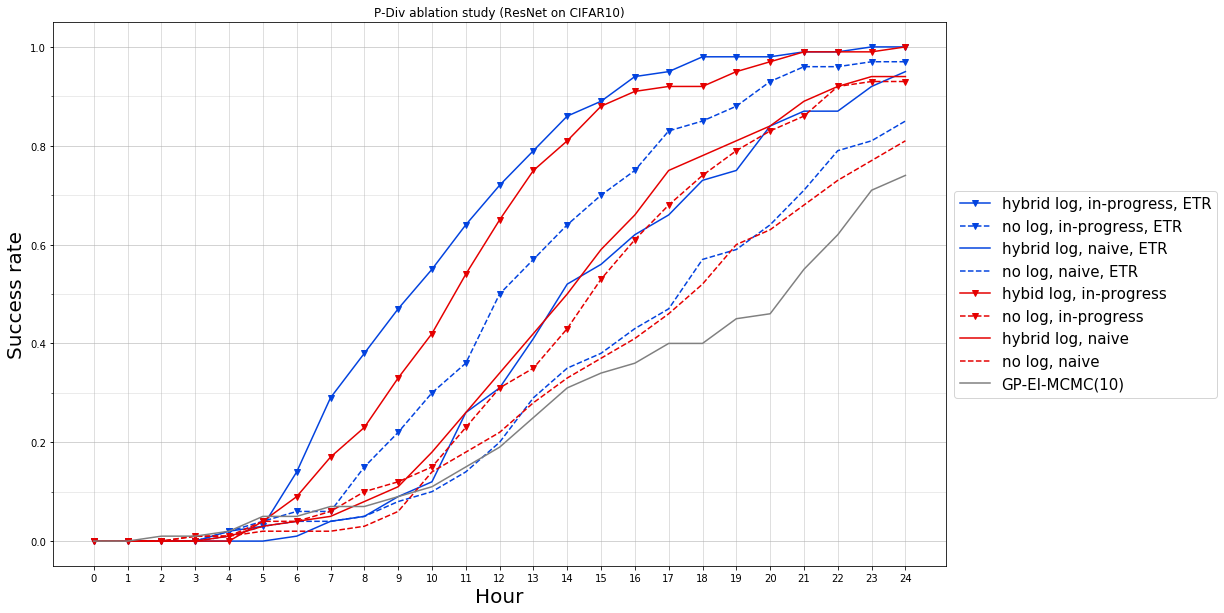

In [6]:
def restyle(name):
    marker = ''
    color ='gray'
    line_style = '-'
    if 'no log' in name:
        line_style = '--'
        
    if 'ETR' in name:
        color = 'xkcd:blue'
    elif 'GP-EI' in name:
        color = 'gray'
    else:
        color = 'xkcd:red'        
    
    if 'naive' in name:
        marker = ''
    elif 'random' in name:
        marker = '^'
    elif 'next candidate' in name:
        marker = 'x'
    elif 'in-progress' in name:
        marker = 'v' 
    
    return marker, color, line_style

parallels = list(ab_results)
print("Remarks:")
print("\tno log: --, hybrid log: -")
print("\tETR: blue, no ETR: red")
print("\trandom: ^, next candidate: x, in-progress: v")
p_g = []
for p in parallels:
    p_g.append({"opt": p})
    
draw_success_rate_fig(ab_results, s['accuracy'], 25, 
                                              x_unit='Hour', step_size=1, style_format=restyle, 
                                               parallel=p_g, 
                      width=16, height=10,  
                      legend={'loc': 'center left', 'bbox_to_anchor':(1, 0.5)},
                      title = 'P-Div ablation study ({})'.format(dataset_name),
                      #save_name='fig-cifar10-resnet-p10', target_folder='./figs/',
                      num_runs=num_trials )

parallels = ['P-Div (in-progress)', 'P-Div (naive)', 'P-Div (random)', 'P-Div (next candidate)']
p_g = []
for p in parallels:
    p_g.append({"opt": p})
draw_success_rate_fig(results_6, s['accuracy'], 31, x_unit="Hour",
                                              step_size=2, style_format=restyle, 
                                               parallel=p_g, 
                                              width=8, height=6,  save_name='fig-cifar10-resnet-p2', target_folder='./figs/',
                                              num_runs=num_trials )

selected = ['Synch. GP-EI-MCMC(10)', 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (in-progress)']

n_p = 6
num_trials = 100
flat_results_6 = {'Synch. GP-EI-MCMC(10)': results_6['Synch. GP-EI-MCMC(10)']}

for opt_name in [ 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (in-progress)']:
    sr_r = flatten_results(n_p, results_6, opt_name, num_trials)
    flat_results_6[opt_name] = sr_r

draw_best_error_curve(flat_results_6, selected, 21, 
                      ylim=(.06, 0.15), xlim=(0, 21), summary=True, guidelines=stats, x_steps=1, style_format=restyle,
                      title="Parallel HPO of {} (6 processors)".format(dataset_name))

# For sequential HPO performance table generation
summary = []
checking_hours = [90] # 30, 60, 90
s_comp_list = ['GP-EI', 'GP-PI', 'GP-UCB', 'RF-EI', 'RF-PI', 'RF-UCB', 'S-Div']
fail_summary = calc_catastrophic_failures(results, s['accuracy'], num_trials, 120)
for key in s_comp_list:
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table1 = pd.DataFrame(summary)
table1

In [7]:
# For parallel HPO performance table generation
summary = []
checking_hours = [15] # , 15, 20
p_comp_list = ['GP-EI-MCMC(10)', 'GP-PI', 'GP-UCB', 'RF-EI',  'RF-PI', 'RF-UCB','P-Div',]
fail_summary = calc_catastrophic_failures(results_6, s['accuracy'], num_trials, 120)
for key in p_comp_list:
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table = pd.DataFrame(summary)
table

,15h,optimizer
0,34.0,GP-EI-MCMC(10)
1,25.0,GP-PI
2,25.0,GP-UCB
3,10.0,RF-EI
4,45.0,RF-PI
5,25.0,RF-UCB
6,61.0,P-Div


In [8]:
# For parallel HPO  ablation performance table generation
summary = []
checking_hours = [15] # , 15, 20
p_comp_list = parallels
fail_summary = calc_catastrophic_failures(ab_results, s['accuracy'], num_trials, 120)
for key in p_comp_list:
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table = pd.DataFrame(summary)
table

,15h,optimizer
0,89.0,"hybrid log, in-progress, ETR"
1,70.0,"no log, in-progress, ETR"
2,56.0,"hybrid log, naive, ETR"
3,38.0,"no log, naive, ETR"
4,88.0,"hybid log, in-progress"
5,53.0,"no log, in-progress"
6,59.0,"hybrid log, naive"
7,37.0,"no log, naive"
8,34.0,GP-EI-MCMC(10)


# Time to success performance table generation
summary2 = []
all_results = {}
all_results.update(results)
times = calc_time_to_achieve(all_results, s['accuracy'], num_trials)
for k in s_comp_list:
        r = times[k]
        ri = {'1_optimizer': k}
        ri['2_mean'] = r['mean']
        ri['3_sd'] = r['sd']
        summary2.append(ri)
    #print("{}: mean {:.2f}, stdev: {:.2f}".format(k, r['mean'], r['sd']))
table2 = pd.DataFrame(summary2)
table2

# Time to success performance table generation
summary2 = []
all_results = {}
all_results.update(results_6)
times = calc_time_to_achieve(all_results, s['accuracy'], num_trials)
for k in p_comp_list:
        r = times[k]
        ri = {'1_optimizer': k}
        ri['2_mean'] = r['mean']
        ri['3_sd'] = r['sd']
        summary2.append(ri)
    #print("{}: mean {:.2f}, stdev: {:.2f}".format(k, r['mean'], r['sd']))
table2 = pd.DataFrame(summary2)
table2

In [9]:
# Time to success performance table generation
summary3 = []
all_results = {}
all_results.update(results_6)
p_comp_list = parallels
times = calc_time_to_achieve(ab_results, s['accuracy'], num_trials)
for k in p_comp_list:
        r = times[k]
        ri = {'1_optimizer': k}
        ri['2_mean'] = r['mean']
        ri['3_sd'] = r['sd']
        summary3.append(ri)
    #print("{}: mean {:.2f}, stdev: {:.2f}".format(k, r['mean'], r['sd']))
table3 = pd.DataFrame(summary3)
table3

,1_optimizer,2_mean,3_sd
0,"hybrid log, in-progress, ETR",9.883411,3.808226
1,"no log, in-progress, ETR",12.795115,4.799908
2,"hybrid log, naive, ETR",14.959984,4.909844
3,"no log, naive, ETR",17.559444,6.626169
4,"hybid log, in-progress",10.950706,3.949894
5,"no log, in-progress",15.004427,5.469441
6,"hybrid log, naive",14.505960,5.266874
7,"no log, naive",17.861578,6.667553
8,GP-EI-MCMC(10),19.222183,7.612787
